In [8]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException
from mlflow.models import infer_signature
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import hashlib
import json
from datetime import datetime

In [9]:
def get_data_hash(X):
    """データのハッシュ値を計算"""
    return hashlib.md5(X.tobytes()).hexdigest()

def log_feature_importance(model, feature_names):
    """特徴量の重要度を記録"""
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 特徴量の重要度をプロット
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    
    # プロットを保存
    plot_path = 'feature_importance.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    
    # 重要度をメトリクスとして記録
    for idx, row in importance.iterrows():
        mlflow.log_metric(f"importance_{row['feature']}", row['importance'])
    
    return importance

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'CaliforniaHousingModel' already exists. Creating a new version of this model...
2025/06/10 14:41:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaliforniaHousingModel, version 3
Created version '3' of model 'CaliforniaHousingModel'.


Experiment completed. Run ID: d3bd8b1a876a4b8bbbe38afccfc80ebd
Metrics: {'rmse': 0.5066213601812409, 'r2_score': 0.8044515355653502, 'mae': 0.33245245260791007}

Feature Importance:
      feature  importance
0      MedInc    0.527033
5    AveOccup    0.137992
6    Latitude    0.086025
7   Longitude    0.085831
1    HouseAge    0.054593
2    AveRooms    0.047137
4  Population    0.031580
3   AveBedrms    0.029808


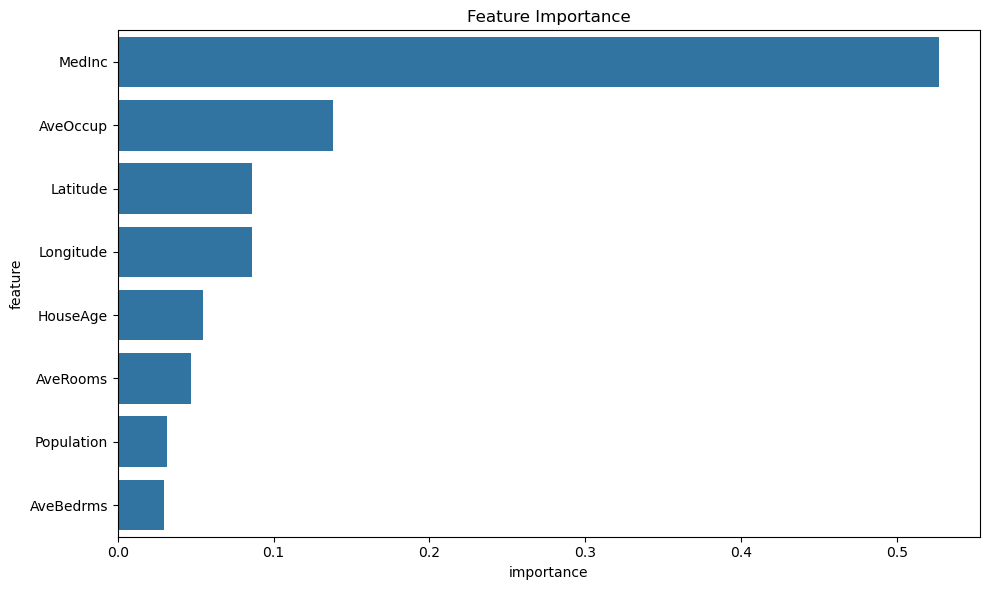

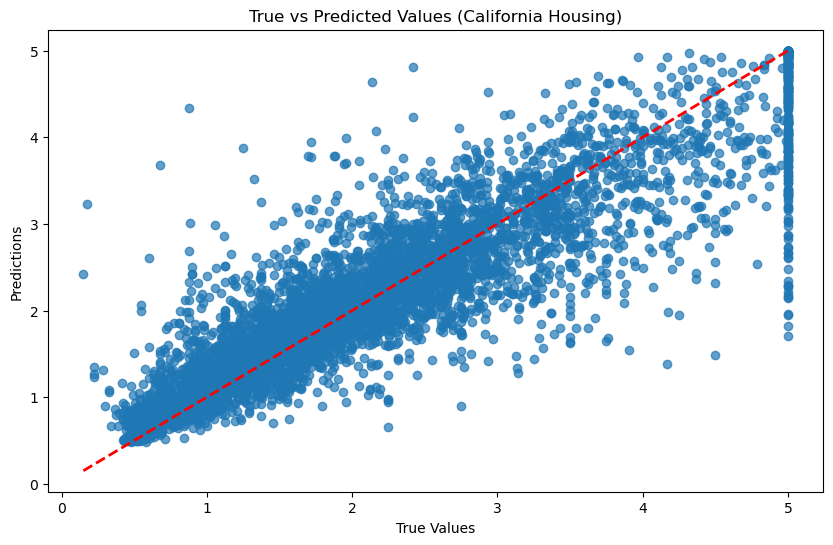

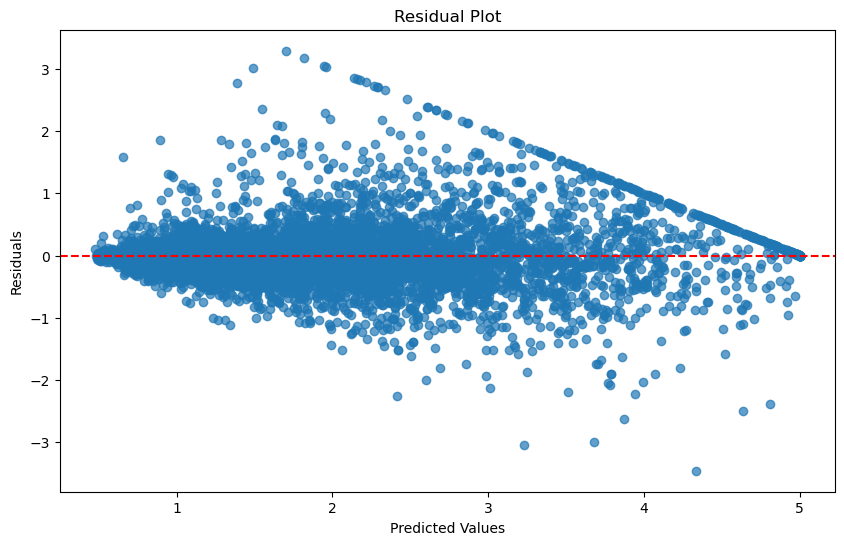

In [10]:
def main():
    # MLflowの設定
    mlflow.set_tracking_uri("http://mlflow:5010")
    mlflow.set_experiment("California Housing Price Prediction")

    # データの読み込み
    california = fetch_california_housing()
    X = california.data
    y = california.target
    feature_names = california.feature_names

    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 実行（Run）の開始
    with mlflow.start_run() as run:
        # 実験のメタデータを記録
        mlflow.set_tag("mlflow.runName", f"california_housing_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        mlflow.set_tag("mlflow.user", "admin")
        
        # モデルのパラメータ
        params = {
            "n_estimators": 100,
            "max_depth": 20,
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "random_state": 42
        }
        
        # パラメータを記録
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)
        
        # モデルの構築
        reg = RandomForestRegressor(**params)
        
        # クロスバリデーションスコアの計算と記録
        cv_scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)
        mlflow.log_metric("cv_rmse_mean", cv_rmse.mean())
        mlflow.log_metric("cv_rmse_std", cv_rmse.std())
        
        # モデルの学習
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        # 評価メトリクスの計算と記録
        metrics = {
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
            "r2_score": r2_score(y_test, y_pred),
            "mae": mean_absolute_error(y_test, y_pred)
        }
        
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)
        
        # データバージョン管理
        data_hash = get_data_hash(X_train)
        mlflow.log_param("data_hash", data_hash)
        
        # 特徴量の重要度を記録
        feature_importance = log_feature_importance(reg, feature_names)
        
        # 予測vs実測値のプロット
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('True vs Predicted Values (California Housing)')
        
        # プロットを保存
        plot_path = 'true_vs_predicted.png'
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        
        # 残差プロット
        plt.figure(figsize=(10, 6))
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        
        # プロットを保存
        residual_plot_path = 'residual_plot.png'
        plt.savefig(residual_plot_path)
        mlflow.log_artifact(residual_plot_path)
        
        # モデルの保存
        signature = infer_signature(X_train, y_pred)
        input_example = X_train[:5]
        
        mlflow.sklearn.log_model(
            sk_model=reg,
            artifact_path="random_forest_regressor_model",
            signature=signature,
            input_example=input_example,
            registered_model_name="CaliforniaHousingModel"
        )
        
        # 実験の詳細情報を記録
        experiment_details = {
            "run_id": run.info.run_id,
            "experiment_id": run.info.experiment_id,
            "status": run.info.status,
            "start_time": run.info.start_time,
            "end_time": run.info.end_time,
            "metrics": metrics,
            "params": params,
            "feature_importance": feature_importance.to_dict()
        }
        
        # 実験の詳細をJSONファイルとして保存
        with open('experiment_details.json', 'w') as f:
            json.dump(experiment_details, f, indent=2)
        mlflow.log_artifact('experiment_details.json')
        
        print(f"Experiment completed. Run ID: {run.info.run_id}")
        print(f"Metrics: {metrics}")
        print("\nFeature Importance:")
        print(feature_importance)

if __name__ == "__main__":
    main() 